In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
import pandas as pd

In [2]:
!pip install transformers

     |████████████████████████████████| 3.5 MB 5.3 MB/s 
     |████████████████████████████████| 596 kB 35.6 MB/s 
     |████████████████████████████████| 67 kB 4.5 MB/s 
     |████████████████████████████████| 895 kB 32.4 MB/s 
     |████████████████████████████████| 6.8 MB 32.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [3]:
!pip install datasets

     |████████████████████████████████| 311 kB 5.2 MB/s 
     |████████████████████████████████| 134 kB 43.0 MB/s 
     |████████████████████████████████| 1.1 MB 44.7 MB/s 
     |████████████████████████████████| 243 kB 50.0 MB/s 
     |████████████████████████████████| 94 kB 2.1 MB/s 
     |████████████████████████████████| 144 kB 37.7 MB/s 
     |████████████████████████████████| 271 kB 37.0 MB/s 


In [4]:
df=pd.read_csv('/content/drive/MyDrive/IT350/mqp.csv',names=['doctorID','question1','question2','label'],header=None)
del df['doctorID']
df

,question1,question2,label
0,After how many hour from drinking an antibioti...,I have a party tonight and I took my last dose...,1
1,After how many hour from drinking an antibioti...,I vomited this morning and I am not sure if it...,0
2,Am I over weight (192.9) for my age (39)?,I am a 39 y/o male currently weighing about 19...,1
3,Am I over weight (192.9) for my age (39)?,What diet is good for losing weight? Keto or v...,0
4,Aspirin allergy - is it worth getting a bracelet?,How much Aspirin can I take for my headache wi...,0
...,...,...,...
3043,15 million sperm can be a father?,My sperm count is 15 millions and is there a c...,1
3044,26 yo m with history of progressive venous ins...,"Hello doctor, can you please tell me some of t...",0
3045,26 yo m with history of progressive venous ins...,"Hello doctor, I am 26 year old male wth progre...",1
3046,32 weeks pregnant. Headache strange leg weakne...,I am 32 weeks pregnant and had severe headache...,0


In [5]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.25)
train.to_csv('/content/drive/MyDrive/IT350/train.csv',index=False)
test.to_csv('/content/drive/MyDrive/IT350/test.csv',index=False)

In [6]:
from datasets import load_dataset

In [7]:
raw_dataset = load_dataset('csv', data_files={'train': '/content/drive/MyDrive/IT350/train.csv',
                                              'test': '/content/drive/MyDrive/IT350/test.csv'})

Using custom data configuration default-fc3614cf62b2b975


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-fc3614cf62b2b975/0.0.0/6b9057d9e23d9d8a2f05b985917a0da84d70c5dae3d22ddd8a3f22fb01c69d9e. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [8]:
raw_dataset

DatasetDict({
    train: Dataset({
        features: ['question1', 'question2', 'label'],
        num_rows: 2286
    })
    test: Dataset({
        features: ['question1', 'question2', 'label'],
        num_rows: 762
    })
})

In [45]:
df.dtypes

question1    object
question2    object
label         int64
dtype: object

In [9]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

In [10]:
raw_dataset['train'].features

{'label': Value(dtype='int64', id=None),
 'question1': Value(dtype='string', id=None),
 'question2': Value(dtype='string', id=None)}

In [11]:
def tokenize_function(examples):
    return tokenizer(examples["question1"],examples["question2"], padding="max_length", truncation=True)


tokenized_datasets = raw_dataset.map(tokenize_function, batched=True)

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [12]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['question1', 'question2', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2286
    })
    test: Dataset({
        features: ['question1', 'question2', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 762
    })
})

In [13]:
small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(100))
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(20))
full_train_dataset = tokenized_datasets["train"]
full_eval_dataset = tokenized_datasets["test"]

In [14]:
import tensorflow as tf
from transformers import TFAutoModelForSequenceClassification

model = TFAutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=2)

Downloading:   0%|          | 0.00/502M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
tf_train_dataset = full_train_dataset.remove_columns(["question1","question2"]).with_format("tensorflow")
tf_eval_dataset = full_eval_dataset.remove_columns(["question1","question2"]).with_format("tensorflow")

In [16]:
train_features = {x: tf_train_dataset[x] for x in tokenizer.model_input_names}
train_tf_dataset = tf.data.Dataset.from_tensor_slices((train_features, tf_train_dataset["label"]))
train_tf_dataset = train_tf_dataset.shuffle(len(tf_train_dataset)).batch(8)

eval_features = {x: tf_eval_dataset[x] for x in tokenizer.model_input_names}
eval_tf_dataset = tf.data.Dataset.from_tensor_slices((eval_features, tf_eval_dataset["label"]))
eval_tf_dataset = eval_tf_dataset.batch(8)

In [17]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=tf.metrics.SparseCategoricalAccuracy(),
)

history=model.fit(train_tf_dataset, validation_data=eval_tf_dataset, epochs=3)
# Calling `save('my_model.h5')` creates a h5 file `my_model.h5`.
model.save('/content/drive/MyDrive/IT350/mqp_model.h5')

# It can be used to reconstruct the model identically.
#reconstructed_model = keras.models.load_model('/content/drive/MyDrive/IT350/mqp_model.h5')

# Let's check:
#np.testing.assert_allclose(
 #   model.predict(test_input), reconstructed_model.predict(test_input)
#)

# The reconstructed model is already compiled and has retained the optimizer
# state, so training can resume:
# reconstructed_model.fit(test_input, test_target)

Epoch 1/3
286/286 [==============================] - 600s 2s/step - loss: 0.5433 - sparse_categorical_accuracy: 0.7428 - val_loss: 0.4956 - val_sparse_categorical_accuracy: 0.7677
Epoch 2/3
286/286 [==============================] - 569s 2s/step - loss: 0.3320 - sparse_categorical_accuracy: 0.8670 - val_loss: 0.5219 - val_sparse_categorical_accuracy: 0.7743
Epoch 3/3
286/286 [==============================] - 570s 2s/step - loss: 0.1766 - sparse_categorical_accuracy: 0.9396 - val_loss: 0.6477 - val_sparse_categorical_accuracy: 0.7769


NotImplementedError: ignored

In [19]:
history.history.keys()

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])

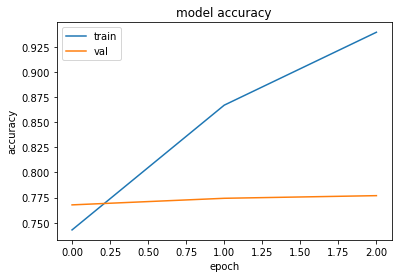

In [20]:
import matplotlib.pyplot as plt
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()